# Caroline's raw material planning

<img align='right' src='https://drive.google.com/uc?export=view&id=1FYTs46ptGHrOaUMEi5BzePH9Gl3YM_2C' width=200>

As we know, BIM produces logic and memory chips using copper, silicon, germanium and plastic. 

Each chip has the following consumption of materials:

| chip   | copper | silicon | germanium | plastic |
|:-------|-------:|--------:|----------:|--------:|
|Logic   |    0.4 |       1 |           |       1 |
|Memory  |    0.2 |         |         1 |       1 |

BIM hired Caroline to manage the acquisition and the inventory of these raw materials. 

Caroline conducted a data analysis which lead to the following prediction of monthly demands for her trophies: 

| chip   | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|:-------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|Logic   |  88 | 125 | 260 | 217 | 238 | 286 | 248 | 238 | 265 | 293 | 259 | 244 |
|Memory  |  47 |  62 |  81 |  65 |  95 | 118 |  86 |  89 |  82 |  82 |  84 | 66  |

As you recall, BIM has the following stock at the moment:

|copper|silicon|germanium|plastic|
|-----:|------:|--------:|------:|
|   480|  1000 |     1500|  1750 |

BIM would like to have at least the following stock at the end of the year:

|copper|silicon|germanium|plastic|
|-----:|------:|--------:|------:|
|   200|   500 |      500|  1000 |

Each product can be acquired at each month, but the unit prices vary as follows:

| product  | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|:---------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|copper    |   1 |   1 |   1 |   2 |   2 |   3 |   3 |   2 |   2 |   1 |   1 |   2 |
|silicon   |   4 |   3 |   3 |   3 |   5 |   5 |   6 |   5 |   4 |   3 |   3 |   5 |
|germanium |   5 |   5 |   5 |   3 |   3 |   3 |   3 |   2 |   3 |   4 |   5 |   6 |
|plastic   | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 |

The inventory is limited by a capacity of a total of 9000 units per month, regardless of the composition of products in stock. 
The holding costs of the inventory are 0.05 per unit per month regardless of the product.

Caroline cannot spend more than 5000 per month on acquisition.

Note that Caroline aims at minimizing the acquisition and holding costs of the materials while meeting the required quantities for production. 
The production is made to order, meaning that no inventory of chips is kept.

Please help Caroline to model the material planning and solve it with the data above. 

In [95]:
import sys
if 'google.colab' in sys.modules:
    import shutil
    if not shutil.which('pyomo'):
        !pip install -q pyomo
        assert(shutil.which('pyomo'))

    # cbc
    !apt-get install -y -qq coinor-cbc

To be self contained... alternative is to upload and read a file. 

In [96]:
demand_data = '''chip,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Logic,88,125,260,217,238,286,248,238,265,293,259,244
Memory,47,62,81,65,95,118,86,89,82,82,84,66'''

In [97]:
from io import StringIO
import pandas as pd
demand_chips = pd.read_csv( StringIO(demand_data), index_col='chip' )
demand_chips

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
Logic,88,125,260,217,238,286,248,238,265,293,259,244
Memory,47,62,81,65,95,118,86,89,82,82,84,66


In [98]:
price_data = '''product,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
copper,1,1,1,2,2,3,3,2,2,1,1,2
silicon,4,3,3,3,5,5,6,5,4,3,3,5
germanium,5,5,5,3,3,3,3,2,3,4,5,6
plastic,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1'''

In [99]:
price = pd.read_csv( StringIO(price_data), index_col='product' )
price

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
product,,,,,,,,,,,,
copper,1.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0
silicon,4.0,3.0,3.0,3.0,5.0,5.0,6.0,5.0,4.0,3.0,3.0,5.0
germanium,5.0,5.0,5.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,5.0,6.0
plastic,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


# A possible resolution

## A simple dataframe with the consumptions

In [100]:
use = dict()
use['Logic'] = { 'silicon' : 1, 'plastic' : 1, 'copper' : 4 }
use['Memory'] = { 'germanium' : 1, 'plastic' : 1, 'copper' : 2 }
use = pd.DataFrame.from_dict( use ).fillna(0).astype( int )
use

,Logic,Memory
silicon,1,0
plastic,1,1
copper,4,2
germanium,0,1


## A simple matrix multiplication

In [101]:
demand = use.dot( demand_chips )
demand

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,88,125,260,217,238,286,248,238,265,293,259,244
plastic,135,187,341,282,333,404,334,327,347,375,343,310
copper,446,624,1202,998,1142,1380,1164,1130,1224,1336,1204,1108
germanium,47,62,81,65,95,118,86,89,82,82,84,66


In [102]:
import pyomo.environ as pyo

In [103]:
def ShowTableOfPyomoVariables( X, I, J ):
    return pd.DataFrame.from_records( [ [ pyo.value( X[i,j] ) for j in J ] for i in I ], index=I, columns=J )

# NOTE: The functions below follow closely the naming in Overleaf

In [104]:
def VersionOne( demand, acquisition_price, existing, desired, stock_limit, month_budget ):
    m = pyo.ConcreteModel( 'Product acquisition and inventory' )
    
    periods  = demand.columns
    products = demand.index 
    first    = periods[0] 
    prev     = { j : i for i,j in zip(periods,periods[1:]) }
    last     = periods[-1]
    
    m.T = pyo.Set( initialize=periods )
    m.P = pyo.Set( initialize=products )
    
    m.PT = m.P * m.T # to avoid internal set bloat
    
    m.x = pyo.Var( m.PT, within=pyo.NonNegativeReals )
    m.s = pyo.Var( m.PT, within=pyo.NonNegativeReals )
    
    @m.Param( m.PT )
    def pi(m,p,t):
        return acquisition_price.loc[p][t]
    
    @m.Param( m.PT )
    def h(m,p,t): 
        return .05 # the holding cost
    
    @m.Param( m.PT )
    def delta(m,t,p):
        return demand.loc[t,p]
    
    @m.Expression()
    def acquisition_cost( m ):
        return pyo.quicksum( m.pi[p,t] * m.x[p,t] for p in m.P for t in m.T )
    
    @m.Expression()
    def inventory_cost( m ):
        return pyo.quicksum( m.h[p,t] * m.s[p,t] for p in m.P for t in m.T )
    
    @m.Objective( sense=pyo.minimize )
    def total_cost( m ):
        return m.acquisition_cost + m.inventory_cost
    
    @m.Constraint( m.PT )
    def balance( m, p, t ):
        if t == first:
            return existing[p] + m.x[p,t] == m.delta[p,t] + m.s[p,t]
        else:
            return m.x[p,t] + m.s[p,prev[t]] == m.delta[p,t] + m.s[p,t]
        
    @m.Constraint( m.P )
    def finish( m, p ):
        return m.s[p,last] >= desired[p]
    
    @m.Constraint( m.T )
    def inventory( m, t ):
        return pyo.quicksum( m.s[p,t] for p in m.P ) <= stock_limit
    
    @m.Constraint( m.T )
    def budget( m, t ):
        return pyo.quicksum( m.pi[p,t]*m.x[p,t] for p in m.P ) <= month_budget
    
    return m

In [105]:
m = VersionOne( demand, price, 
           {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800 }, 
           {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000 },
           9000, 2000 )

pyo.SolverFactory( 'gurobi_direct' ).solve(m)

{'Problem': [{'Name': 'Product acquisition and inventory', 'Lower bound': 25908.129166666662, 'Upper bound': 25908.129166666662, 'Number of objectives': 1, 'Number of constraints': 76, 'Number of variables': 96, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 96, 'Number of nonzeros': 240, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.50', 'Status': 'ok', 'Wallclock time': 0.0010051727294921875, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [106]:
ShowTableOfPyomoVariables( m.x, m.P, m.T ).round(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,444.67,559.0,0.0,666.67,0.0,400.0,65.05,0.00,125.62,0.0,0.0,0.0
plastic,0.00,0.0,0.0,0.00,0.0,0.0,266.00,327.00,1065.00,0.0,0.0,1310.0
copper,221.33,323.0,2000.0,0.00,1000.0,0.0,0.00,983.65,695.52,2000.0,2000.0,934.5
germanium,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0


In [107]:
ShowTableOfPyomoVariables( m.s, m.P, m.T ).round(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,1356.67,1790.67,1530.67,1980.33,1742.33,1856.33,1673.38,1435.38,1296.0,1003.0,744.0,500.0
plastic,1615.00,1428.00,1087.00,805.00,472.00,68.00,0.00,0.00,718.0,343.0,0.0,1000.0
copper,4575.33,4274.33,5072.33,4074.33,3932.33,2552.33,1388.33,1241.98,713.5,1377.5,2173.5,2000.0
germanium,1453.00,1391.00,1310.00,1245.00,1150.00,1032.00,946.00,857.00,775.0,693.0,609.0,543.0


In [108]:
def VersionTwo( demand, acquisition_price, existing, desired, stock_limit, month_budget ):
    m = pyo.ConcreteModel( 'Product acquisition and inventory' )
    
    periods  = demand.columns
    products = demand.index 
    first    = periods[0] 
    prev     = { j : i for i,j in zip(periods,periods[1:]) }
    last     = periods[-1]
    
    m.T = pyo.Set( initialize=periods )
    m.P = pyo.Set( initialize=products )
    
    m.PT = m.P * m.T # to avoid internal set bloat
    
    m.x = pyo.Var( m.PT, within=pyo.NonNegativeReals )
    
    @m.Param( m.PT )
    def pi(m,p,t):
        return acquisition_price.loc[p][t]
    
    @m.Param( m.PT )
    def h(m,p,t): 
        return .05 # the holding cost
    
    @m.Param( m.PT )
    def delta(m,t,p):
        return demand.loc[t,p]
    
    @m.Expression( m.PT )
    def s( m, p, t ):
        if t == first:
            return existing[p] + m.x[p,t] - m.delta[p,t]
        else:
            return m.x[p,t] + m.s[p,prev[t]] - m.delta[p,t]
        
    @m.Constraint( m.PT )
    def non_negative_stock( m, p, t ):
        return m.s[p,t] >= 0
    
    @m.Expression()
    def acquisition_cost( m ):
        return pyo.quicksum( m.pi[p,t] * m.x[p,t] for p in m.P for t in m.T )
    
    @m.Expression()
    def inventory_cost( m ):
        return pyo.quicksum( m.h[p,t] * m.s[p,t] for p in m.P for t in m.T )
    
    @m.Objective( sense=pyo.minimize )
    def total_cost( m ):
        return m.acquisition_cost + m.inventory_cost
            
    @m.Constraint( m.P )
    def finish( m, p ):
        return m.s[p,last] >= desired[p]
    
    @m.Constraint( m.T )
    def inventory( m, t ):
        return pyo.quicksum( m.s[p,t] for p in m.P ) <= stock_limit
    
    @m.Constraint( m.T )
    def budget( m, t ):
        return pyo.quicksum( m.pi[p,t]*m.x[p,t] for p in m.P ) <= month_budget
    
    return m

In [109]:
m = VersionTwo( demand, price, 
           {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800 }, 
           {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000 },
           9000, 2000 )

pyo.SolverFactory( 'gurobi_direct' ).solve(m)

{'Problem': [{'Name': 'Product acquisition and inventory', 'Lower bound': 25908.129166666666, 'Upper bound': 25908.129166666666, 'Number of objectives': 1, 'Number of constraints': 76, 'Number of variables': 48, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 48, 'Number of nonzeros': 720, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.50', 'Status': 'ok', 'Wallclock time': 0.0, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [110]:
ShowTableOfPyomoVariables( m.x, m.P, m.T ).round(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,444.67,559.0,0.0,666.67,0.0,400.0,56.88,0.0,133.79,0.0,0.0,0.0
plastic,0.00,0.0,0.0,0.00,0.0,0.0,593.00,0.0,1065.00,0.0,0.0,1310.0
copper,221.33,323.0,2000.0,0.00,1000.0,0.0,0.00,1000.0,679.17,2000.0,2000.0,934.5
germanium,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0


In [111]:
ShowTableOfPyomoVariables( m.s, m.P, m.T ).round(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,1356.67,1790.67,1530.67,1980.33,1742.33,1856.33,1665.21,1427.21,1296.0,1003.0,744.0,500.0
plastic,1615.00,1428.00,1087.00,805.00,472.00,68.00,327.00,0.00,718.0,343.0,0.0,1000.0
copper,4575.33,4274.33,5072.33,4074.33,3932.33,2552.33,1388.33,1258.33,713.5,1377.5,2173.5,2000.0
germanium,1453.00,1391.00,1310.00,1245.00,1150.00,1032.00,946.00,857.00,775.0,693.0,609.0,543.0


In [112]:
m = pyo.ConcreteModel()

# Add the relevant data to the model

In [113]:
m.Time        = demand.columns
m.Product     = demand.index
m.Demand      = demand
m.UnitPrice   = price
m.HoldingCost = .05
m.StockLimit  = 9000
m.Budget      = 2000

In [114]:
m.existing = {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800 }
m.desired  = {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000 }

# Some care to deal with the `time` index

In [115]:
m.first = m.Time[0]
m.last  = m.Time[-1]
m.prev  = { j : i for i,j in zip(m.Time,m.Time[1:]) }

# Variables for the decision (buy) and consequence (stock)

In [116]:
m.buy   = pyo.Var( m.Product, m.Time, within=pyo.NonNegativeReals )
m.stock = pyo.Var( m.Product, m.Time, within=pyo.NonNegativeReals )

# The constraints that balance acquisition with inventory and demand

In [117]:
def BalanceRule( m, p, t ):
    if t == m.first:
        return m.existing[p] + m.buy[p,t] == m.Demand.loc[p,t] + m.stock[p,t]
    else:
        return m.buy[p,t] + m.stock[p,m.prev[t]] == m.Demand.loc[p,t] + m.stock[p,t]

In [118]:
m.balance = pyo.Constraint( m.Product, m.Time, rule = BalanceRule )

# The remaining constraints

Note that these rules are so simple, one liners, that it is better to just define them 'on the spot' as anonymous (or `'lambda`) functions. 

## Ensure the desired inventory at the end of the horizon

In [119]:
m.finish = pyo.Constraint( m.Product, rule = lambda m, p : m.stock[p,m.last] >= m.desired[p] )

## Ensure that the inventory fits the capacity

In [120]:
m.inventory = pyo.Constraint( m.Time, rule = lambda m, t : sum( m.stock[p,t] for p in m.Product ) <= m.StockLimit )

## Ensure that the acquisition fits the budget

In [121]:
m.budget = pyo.Constraint( m.Time, rule = lambda m, t : sum( m.UnitPrice.loc[p,t]*m.buy[p,t] for p in m.Product ) <= m.Budget )

In [122]:
m.obj = pyo.Objective( expr = sum( m.UnitPrice.loc[p,t]*m.buy[p,t] for p in m.Product for t in m.Time )
                              + sum( m.HoldingCost*m.stock[p,t] for p in m.Product for t in m.Time )
                      , sense = pyo.minimize )

In [123]:
pyo.SolverFactory( 'gurobi_direct' ).solve(m)

{'Problem': [{'Name': 'unknown', 'Lower bound': 25908.12916666666, 'Upper bound': 25908.12916666666, 'Number of objectives': 1, 'Number of constraints': 76, 'Number of variables': 96, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 96, 'Number of nonzeros': 240, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.50', 'Status': 'ok', 'Wallclock time': 0.0009899139404296875, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [124]:
ShowTableOfPyomoVariables( m.buy, m.Product, m.Time )

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,444.666667,559.0,0.0,666.666667,0.0,400.0,65.05,0.00,125.616667,0.0,0.0,0.0
plastic,0.000000,0.0,0.0,0.000000,0.0,0.0,266.00,327.00,1065.000000,0.0,0.0,1310.0
copper,221.333333,323.0,2000.0,0.000000,1000.0,0.0,0.00,983.65,695.516667,2000.0,2000.0,934.5
germanium,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0


In [125]:
ShowTableOfPyomoVariables( m.stock, m.Product, m.Time )

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,1356.666667,1790.666667,1530.666667,1980.333333,1742.333333,1856.333333,1673.383333,1435.383333,1296.0,1003.0,744.0,500.0
plastic,1615.000000,1428.000000,1087.000000,805.000000,472.000000,68.000000,0.000000,0.000000,718.0,343.0,0.0,1000.0
copper,4575.333333,4274.333333,5072.333333,4074.333333,3932.333333,2552.333333,1388.333333,1241.983333,713.5,1377.5,2173.5,2000.0
germanium,1453.000000,1391.000000,1310.000000,1245.000000,1150.000000,1032.000000,946.000000,857.000000,775.0,693.0,609.0,543.0


<AxesSubplot:>

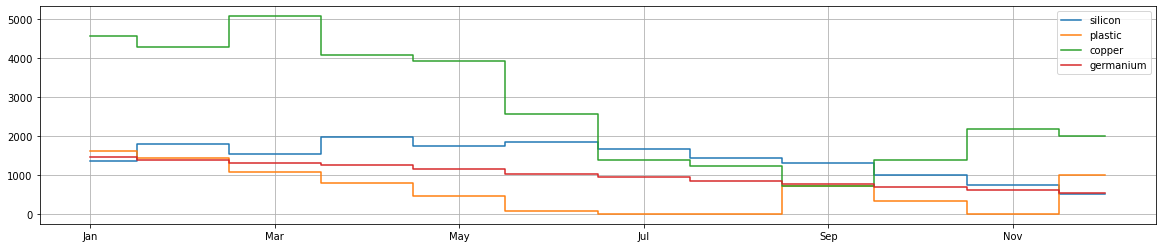

In [126]:
ShowTableOfPyomoVariables( m.stock, m.Product, m.Time ).T.plot(drawstyle='steps-mid',grid=True, figsize=(20,4))

# Notes

* The budget is not limitative. 
* With the given budget the solution remains integer. 
* Lowering the budget to 2000 forces acquiring fractional quantities. 
* Lower values of the budget end up making the problem infeasible.